# test graph.dot
from [here](http://dask.pydata.org/en/latest/inspect.html)

In [1]:
import dask.array as da
x = da.ones((5, 15), chunks=(5, 5))
dict(x.dask)

{('wrapped-230fe55efd3edbef6699831bf3d8f6e1',
  0,
  0): (functools.partial(<function ones at 0x2aaab7dcd840>, dtype=dtype('float64')), (5,
   5)),
 ('wrapped-230fe55efd3edbef6699831bf3d8f6e1',
  0,
  1): (functools.partial(<function ones at 0x2aaab7dcd840>, dtype=dtype('float64')), (5,
   5)),
 ('wrapped-230fe55efd3edbef6699831bf3d8f6e1',
  0,
  2): (functools.partial(<function ones at 0x2aaab7dcd840>, dtype=dtype('float64')), (5,
   5))}

In [2]:
dict((x + 1).dask)

{('add-a9f07c96521f5fe5a50040d90ea7c4b8', 0, 0): (<function _operator.add>,
  ('wrapped-230fe55efd3edbef6699831bf3d8f6e1', 0, 0),
  1),
 ('add-a9f07c96521f5fe5a50040d90ea7c4b8', 0, 1): (<function _operator.add>,
  ('wrapped-230fe55efd3edbef6699831bf3d8f6e1', 0, 1),
  1),
 ('add-a9f07c96521f5fe5a50040d90ea7c4b8', 0, 2): (<function _operator.add>,
  ('wrapped-230fe55efd3edbef6699831bf3d8f6e1', 0, 2),
  1),
 ('wrapped-230fe55efd3edbef6699831bf3d8f6e1',
  0,
  0): (functools.partial(<function ones at 0x2aaab7dcd840>, dtype=dtype('float64')), (5,
   5)),
 ('wrapped-230fe55efd3edbef6699831bf3d8f6e1',
  0,
  1): (functools.partial(<function ones at 0x2aaab7dcd840>, dtype=dtype('float64')), (5,
   5)),
 ('wrapped-230fe55efd3edbef6699831bf3d8f6e1',
  0,
  2): (functools.partial(<function ones at 0x2aaab7dcd840>, dtype=dtype('float64')), (5,
   5))}

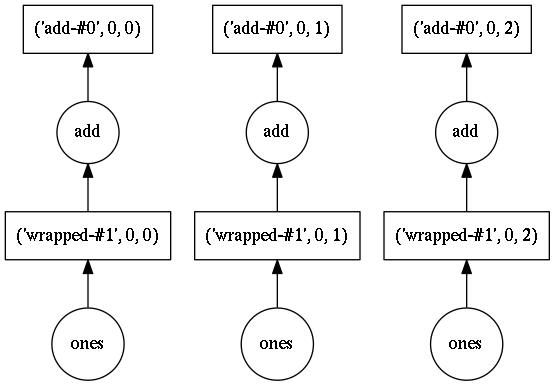

In [3]:
d = (x + 1).dask
from dask.dot import dot_graph
dot_graph(d)

---
# does chunk order matter?

answer is yes

In [4]:
import xarray as xr
import numpy as np

In [5]:
nx, ny, nt = 32, 64, 128

ds = xr.Dataset({}, coords={'x':np.arange(nx),'y':np.arange(ny), 't': np.arange(nt)})

ds = ds.assign(v_cost=np.cos(2.*np.pi*ds.t/100))
ds = ds.assign(v_cosx=np.cos(2.*np.pi/100*ds.x))
ds = ds.assign(v_y=ds.y*1.)
ds['v'] = ds.v_cost*ds.v_cosx*ds.v_y
ds0 = ds

<xarray.Dataset>
Dimensions:  (t: 128, x: 32, y: 64)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v_cost   (t) float64 dask.array<shape=(128,), chunksize=(128,)>
    v_cosx   (x) float64 dask.array<shape=(32,), chunksize=(16,)>
    v_y      (y) float64 dask.array<shape=(64,), chunksize=(16,)>
    v        (t, x, y) float64 dask.array<shape=(128, 32, 64), chunksize=(128, 16, 16)>


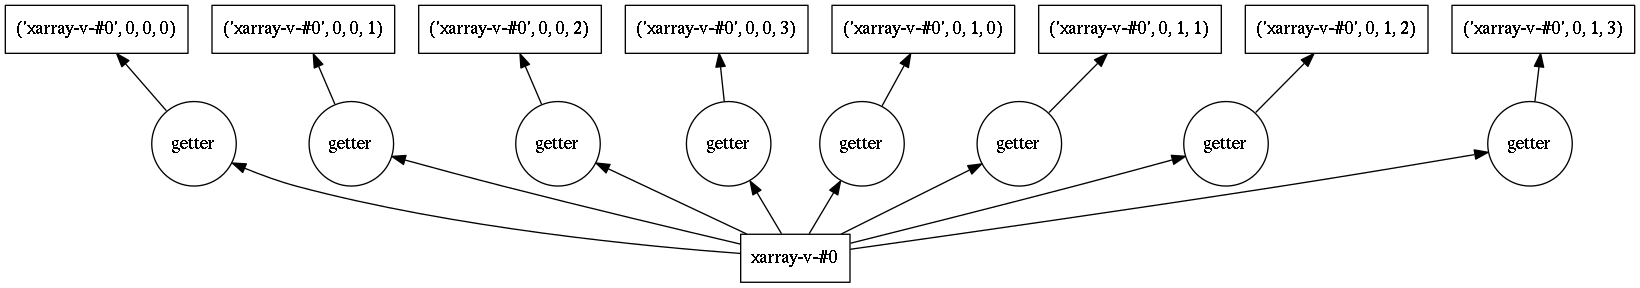

In [6]:
# simultaneous chunking
#ds = ds0.chunk({'x': nx/2})
ds = ds0.chunk({'x': nx/2, 'y': ny/4})
#
ds.persist()
print(ds)
dot_graph(ds.v.data.dask)

<xarray.Dataset>
Dimensions:  (t: 128, x: 32, y: 64)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v_cost   (t) float64 dask.array<shape=(128,), chunksize=(128,)>
    v_cosx   (x) float64 dask.array<shape=(32,), chunksize=(16,)>
    v_y      (y) float64 dask.array<shape=(64,), chunksize=(16,)>
    v        (t, x, y) float64 dask.array<shape=(128, 32, 64), chunksize=(128, 16, 16)>


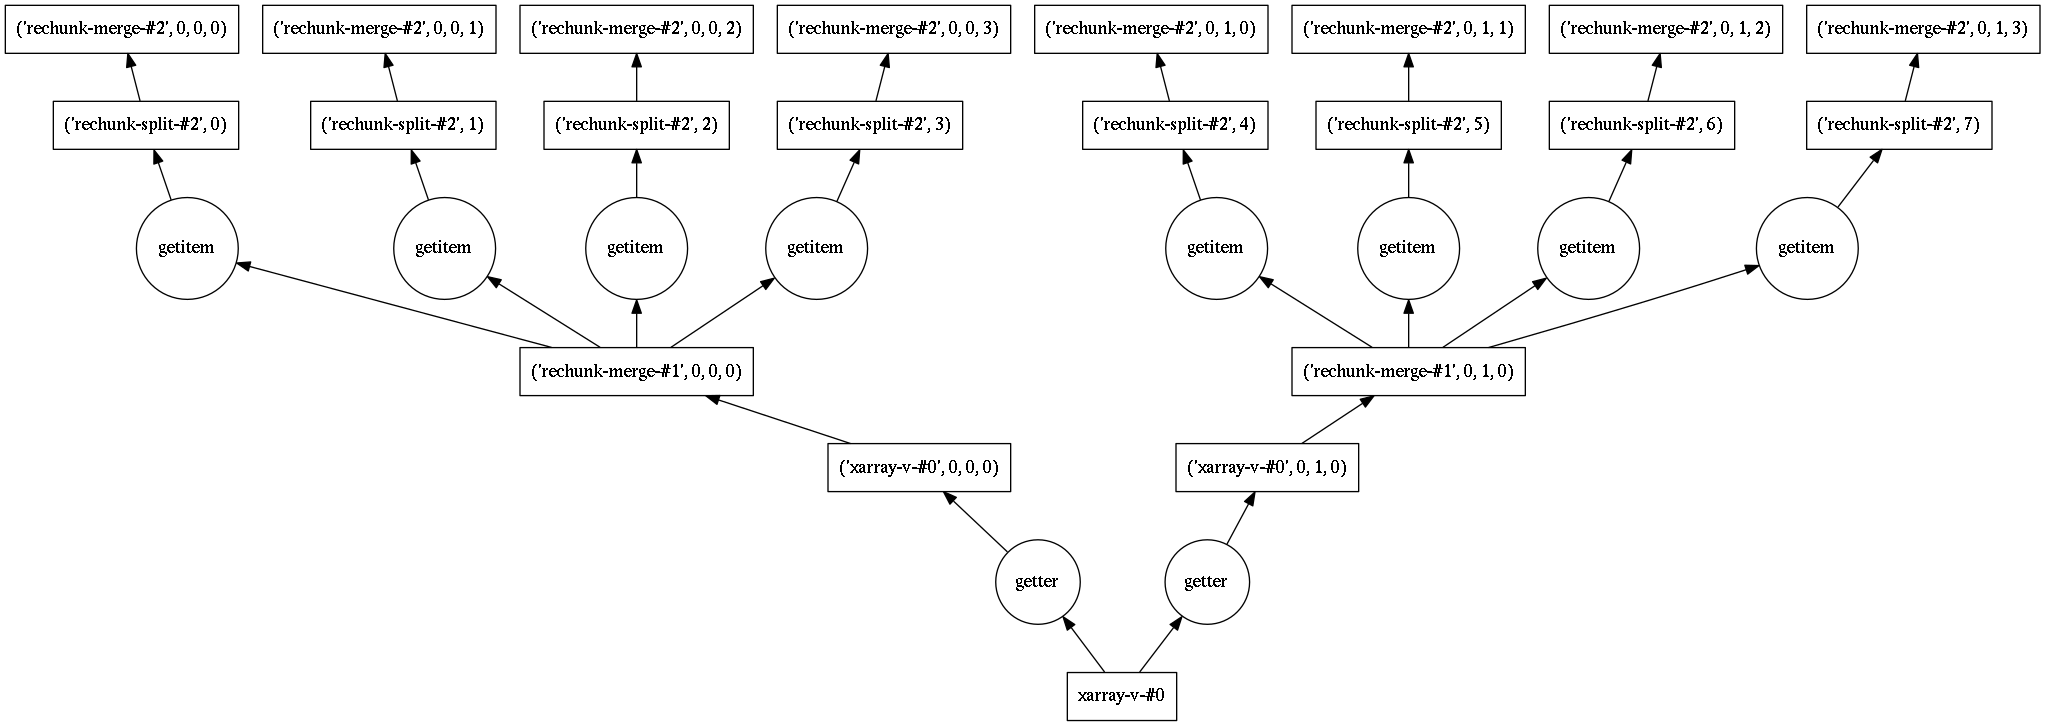

In [7]:
# x then y
ds = ds0.chunk({'x': nx/2})
ds = ds.chunk({'y': ny/4})
print(ds)
dot_graph(ds.v.data.dask)

In [8]:
# store data now
ds.to_zarr('data_xy.zarr', mode='w')

<xarray.Dataset>
Dimensions:  (t: 128, x: 32, y: 64)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v_cost   (t) float64 dask.array<shape=(128,), chunksize=(128,)>
    v_cosx   (x) float64 dask.array<shape=(32,), chunksize=(16,)>
    v_y      (y) float64 dask.array<shape=(64,), chunksize=(16,)>
    v        (t, x, y) float64 dask.array<shape=(128, 32, 64), chunksize=(128, 16, 16)>


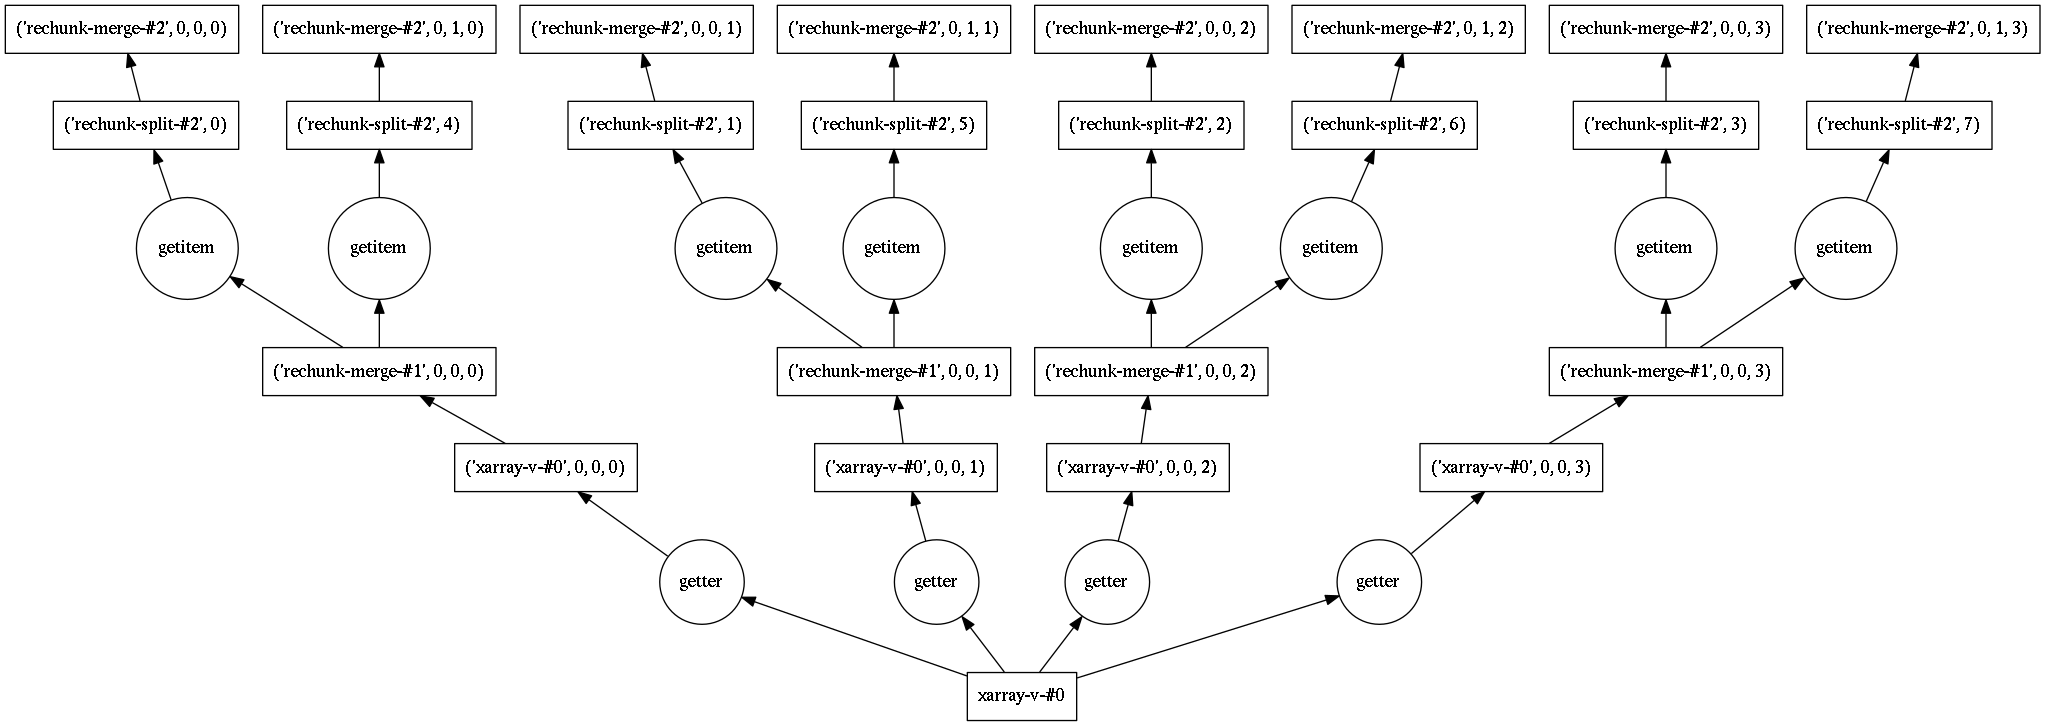

In [9]:
# y then x
ds = ds0.chunk({'y': ny/4})
ds = ds.chunk({'x': nx/2})
print(ds)
dot_graph(ds.v.data.dask)

In [10]:
# store data now
ds.to_zarr('data_yx.zarr', mode='w')

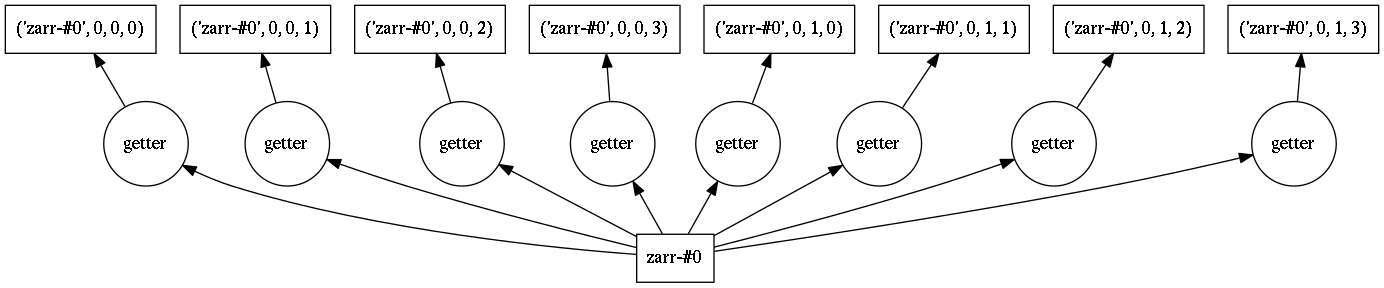

In [11]:
# reopen
ds = xr.open_zarr('data_xy.zarr')
dot_graph(ds.v.data.dask)

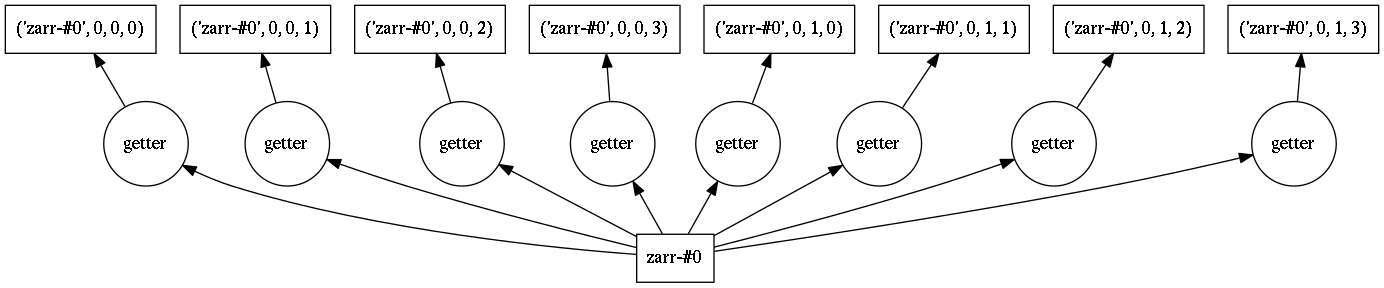

In [12]:
# reopen
ds = xr.open_zarr('data_yx.zarr')
dot_graph(ds.v.data.dask)

---

# simulate mit rechunking

<xarray.Dataset>
Dimensions:  (t: 128, x: 32, y: 64)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v_cost   (t) float64 dask.array<shape=(128,), chunksize=(64,)>
    v_cosx   (x) float64 dask.array<shape=(32,), chunksize=(32,)>
    v_y      (y) float64 dask.array<shape=(64,), chunksize=(64,)>
    v        (t, x, y) float64 dask.array<shape=(128, 32, 64), chunksize=(64, 32, 64)>


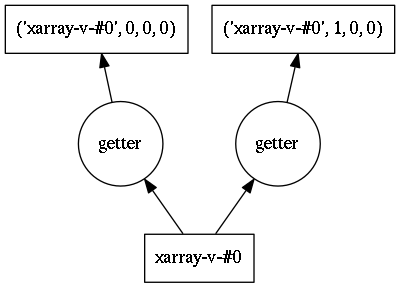

In [13]:
ds = ds0.chunk({'t': nt/2})
#
print(ds)
dot_graph(ds.v.data.dask)

In [14]:
# store data now
ds.to_zarr('data_t.zarr', mode='w')

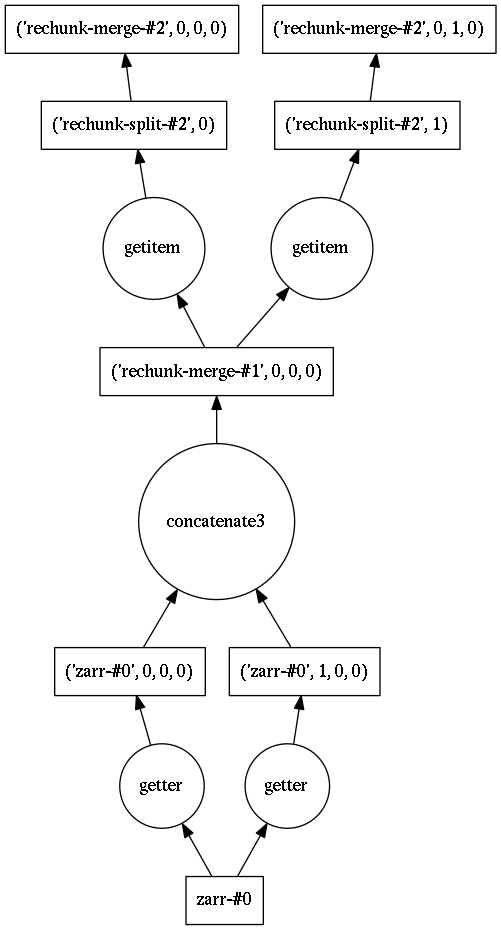

In [21]:
ds = xr.open_zarr('data_t.zarr')
ds = ds.chunk({'t': nt, 'x': nx/2}) # equivalent to rechunking along t then x
#ds = ds.chunk({'x': nx/2, 't': nt}) # the order in the dict does not matter
dot_graph(ds.v.data.dask)

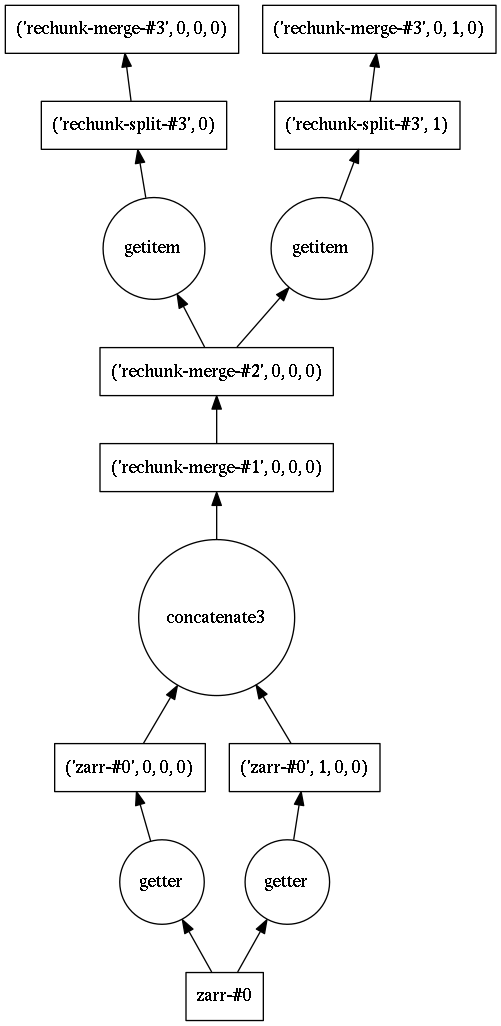

In [18]:
# 
ds = xr.open_zarr('data_t.zarr')
ds = ds.chunk({'t': nt})
ds = ds.chunk({'x': nx/2})
dot_graph(ds.v.data.dask)

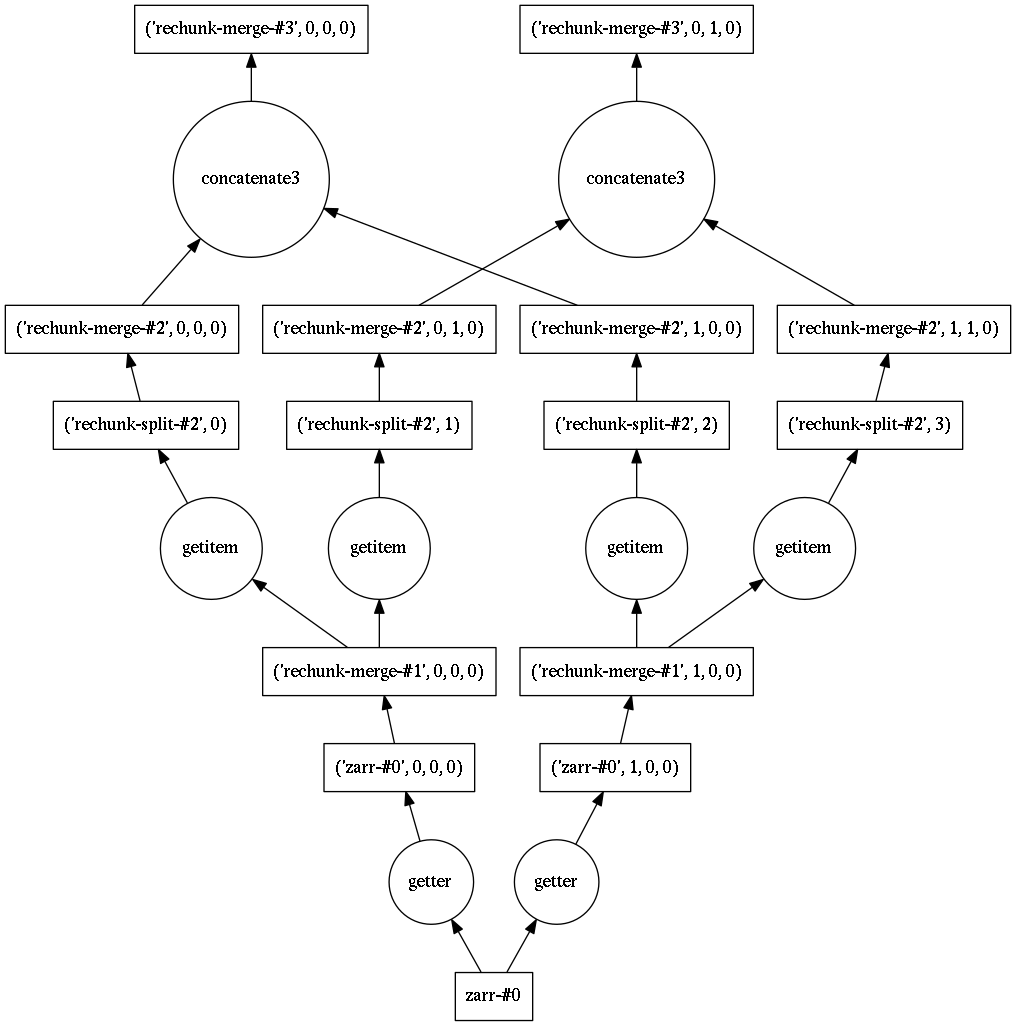

In [17]:
ds = xr.open_zarr('data_t.zarr')
ds = ds.chunk({'x': nx/2})
ds = ds.chunk({'t': nt})
dot_graph(ds.v.data.dask)